### Quora Duplicate Question Model Selection

Now we will load up the dataset of all the final features
and we will test out various models

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings("ignore")

import os
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import xgboost as xgb

In [2]:
# Read 100000 rows randomly
filename = './Data/all_features_final.csv'

# Count the records in file
records_in_file = sum(1 for l in open(filename))
number_of_records_to_be_read = 100000

# The row indices to skip -
# make sure 0 is not included to keep the header!
skip_idx = random.sample(range(1, records_in_file), records_in_file - number_of_records_to_be_read)

data = pd.read_csv(filename , skiprows = skip_idx)

In [3]:
data.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y,96_y,97_y
0,1,1,0,0.799984,0.399996,0.999986,0.874989,0.699993,0.466664,0.0,...,-67.937063,-14.765682,-3.938123,26.130854,169.964593,-55.651786,195.019656,127.96923757,55.5324496,]
1,8,8,0,0.999950,0.999950,0.999986,0.999986,0.999983,0.857131,0.0,...,25.751247,-18.339197,43.787209,-29.630131,3.473063,-23.581781,22.371372,0.8230418,-26.83713213],NaN
2,15,15,1,0.374995,0.299997,0.999988,0.999988,0.249998,0.235293,0.0,...,14.303193,-24.721612,67.589742,-69.354591,-92.129857,-3.560772,75.449690,20.17547396,75.12856992],NaN
3,18,18,1,0.571420,0.499994,0.999986,0.874989,0.384612,0.357140,1.0,...,-32.799907,-12.164617,40.908921,-110.575802,-97.372203,-49.579605,6.561569,-34.69863772,26.2334342,]
4,21,21,0,0.666644,0.666644,0.999983,0.857131,0.571420,0.399996,0.0,...,54.734690,-20.879879,37.027482,-44.004908,-26.254134,-61.200338,64.472702,12.335307,57.39217645],NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 224 entries, Unnamed: 0 to 97_y
dtypes: float64(200), int64(18), object(6)
memory usage: 170.9+ MB


In [5]:
# remove any garbage special characters
object_type_columns = data.select_dtypes(include=['object']).columns
# Convert all columns to numeric
for column in object_type_columns:
    data[column] = data[column].str.replace('\W', '')
    data[column] = data[column].apply(pd.to_numeric)


In [6]:
data.fillna(value = 0,inplace=True)

#### Check Dataset Balance

In [7]:
counts_is_duplicate = data.is_duplicate.value_counts()
counts_is_duplicate

0    63191
1    36808
Name: is_duplicate, dtype: int64

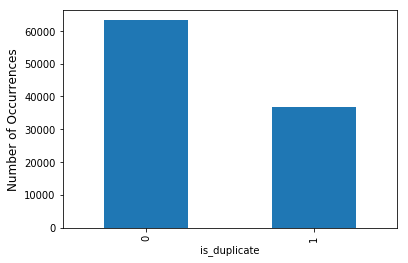

In [8]:
plt.ylabel('Number of Occurrences', fontsize=12)
data.groupby('is_duplicate')['id'].count().plot.bar()

In [9]:
y = data.is_duplicate
data.drop(['is_duplicate'],axis =1 ,inplace =True)
X = data

There is a high imbalance in the dataset , so before we go in and create the model lets try to balance it

In [10]:
# split into train and test samples
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3 ,random_state = 0)

In [11]:
print("Number of records X_train dataset: ", X_train.shape)
print("Number of records y_train dataset: ", y_train.shape)
print("Number of records X_test dataset: ", X_test.shape)
print("Number of records y_test dataset: ", y_test.shape)

Number of records X_train dataset:  (69999, 223)
Number of records y_train dataset:  (69999,)
Number of records X_test dataset:  (30000, 223)
Number of records y_test dataset:  (30000,)


In [12]:
print("Before Oversampling,counts of label '1' : {}".format(sum(y_train==1)))
print("Before Oversampling,counts of label '0' : {}".format(sum(y_train==0)))

Before Oversampling,counts of label '1' : 25864
Before Oversampling,counts of label '0' : 44135


#### Oversampling using SMOTE

In [14]:
sm = SMOTE(random_state=2)
X_train_resampled , y_train_resampled = sm.fit_sample(X_train,y_train.ravel())
print('After OverSampling, the shape of train_X: {}'.format(X_train_resampled.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_resampled.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_resampled==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_resampled==0)))

After OverSampling, the shape of train_X: (88270, 223)
After OverSampling, the shape of train_y: (88270,) 

After OverSampling, counts of label '1': 44135
After OverSampling, counts of label '0': 44135


#### Spliiting data for cross-validation

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=0)

#### XGBoost Classifier

In [20]:
# setting parameters for XGBoost
params = {'objective':'binary:logistic',
          'eval_metric':'logloss',
          'max_depth' : 6
         }

d_train = xgb.DMatrix(X_train,label = y_train)
d_valid = xgb.DMatrix(X_valid,label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.553211	valid-logloss:0.554651
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.303494	valid-logloss:0.316612
[20]	train-logloss:0.270335	valid-logloss:0.293946
[30]	train-logloss:0.25068	valid-logloss:0.288485
[40]	train-logloss:0.230781	valid-logloss:0.286286
[50]	train-logloss:0.215101	valid-logloss:0.285303
[60]	train-logloss:0.201549	valid-logloss:0.284372
[70]	train-logloss:0.190788	valid-logloss:0.284801
[80]	train-logloss:0.178988	valid-logloss:0.284601
[90]	train-logloss:0.167052	valid-logloss:0.284186
[100]	train-logloss:0.155344	valid-logloss:0.28521
[110]	train-logloss:0.145043	valid-logloss:0.284996
[120]	train-logloss:0.135643	valid-logloss:0.285822
[130]	train-logloss:0.127514	valid-logloss:0.285861
Stopping. Best iteration:
[87]	train-logloss:0.169888	valid-logloss:0.283854



#### We have achieved a log loss errors of 0.283854 on validation set

#### TODO- Preprocess the test.csv to add features and try the prediction on the test set